# Wine Quality – Exploratory Data Analysis (Risk Perspective)

This notebook explores the relationship between chemical composition and low technical wine quality.
The analysis is framed from a risk prevention perspective, focusing on identifying patterns associated with low-quality outcomes.
Findings from this EDA are used to inform later modeling decisions, not to build predictive models.



In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]



In [2]:
wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)


In [3]:
wine_quality.shape


(1143, 13)

In [4]:
# --- Keep only the original Wine Quality columns (avoid contamination from engineered columns)
BASE_COLS = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
    "quality",
]

missing_base = [c for c in BASE_COLS if c not in wine_quality.columns]
if missing_base:
    raise ValueError(f"Missing expected base columns in loaded dataset: {missing_base}")

wine_quality = wine_quality[BASE_COLS].copy()

# --- Risk definition (reproducible)
wine_quality["risk"] = (wine_quality["quality"] <= 5).astype(int)

wine_quality[["quality", "risk"]].head()


,quality,risk
0,5,1
1,5,1
2,5,1
3,6,0
4,5,1


In [5]:
wine_quality.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  risk                  1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [6]:
wine_quality.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,risk
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,0.456693
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,0.498339
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,0.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


## Data sanity checks and range inspection

Before proceeding with any modeling or interpretation, we inspect the minimum and maximum values of the physicochemical variables.
This step is intended as a **data validation and sanity check**, not as a feature scaling procedure.

The goal is to identify potential outliers or implausible values that could indicate data quality issues.



In [7]:
# Min and max values for each feature
range_check = wine_quality.describe().loc[["min", "max"]]
range_check


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,risk
min,4.6,0.12,0.0,0.9,0.012,1.0,6.0,0.99007,2.74,0.33,8.4,3.0,0.0
max,15.9,1.58,1.0,15.5,0.611,68.0,289.0,1.00369,4.01,2.00,14.9,8.0,1.0


In [8]:
# Additional percentile inspection for potential outliers
percentile_check = wine_quality.describe(percentiles=[0.01, 0.05, 0.95, 0.99])
percentile_check


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,risk
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,0.456693
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,0.498339
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
1%,5.142000,0.194200,0.000000,1.400000,0.041420,3.000000,8.000000,0.991750,2.930000,0.420000,9.000000,4.000000,0.000000
5%,6.100000,0.271000,0.000000,1.600000,0.054000,4.000000,12.000000,0.993602,3.070000,0.470000,9.200000,5.000000,0.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,0.000000
95%,11.900000,0.840000,0.619000,5.195000,0.123000,35.000000,112.000000,1.000000,3.570000,0.930000,12.500000,7.000000,1.000000
99%,13.300000,1.020000,0.730000,8.216000,0.350860,48.000000,143.000000,1.002100,3.695800,1.243200,13.496667,8.000000,1.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


In [9]:
wine_quality.isna().sum()


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
risk                    0
dtype: int64

In [10]:
wine_quality.duplicated().sum()


np.int64(125)

In [11]:
corr = wine_quality.corr(numeric_only=True)
corr["quality"].sort_values(ascending=False)


quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
risk                   -0.846007
Name: quality, dtype: float64

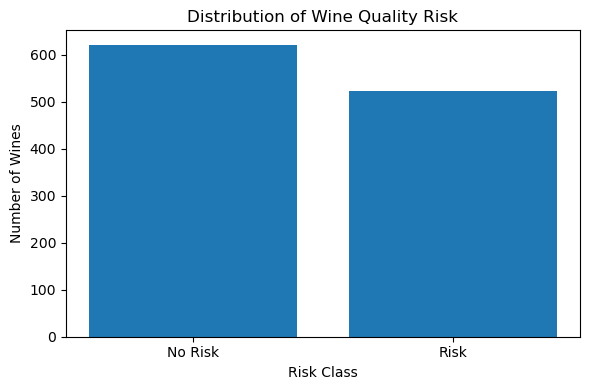

In [12]:
import matplotlib.pyplot as plt

# Count risk classes
risk_counts = wine_quality['risk'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(
    risk_counts.index.astype(str),
    risk_counts.values
)

# Custom x-axis labels
plt.xticks(
    ticks=[0, 1],
    labels=[
        'No Risk',
        'Risk'
    ]
)

# Labels and title
plt.xlabel('Risk Class')
plt.ylabel('Number of Wines')
plt.title('Distribution of Wine Quality Risk')

# Save figure for slides
plt.tight_layout()
plt.savefig('../figures/risk_distribution.png', dpi=300)

plt.show()


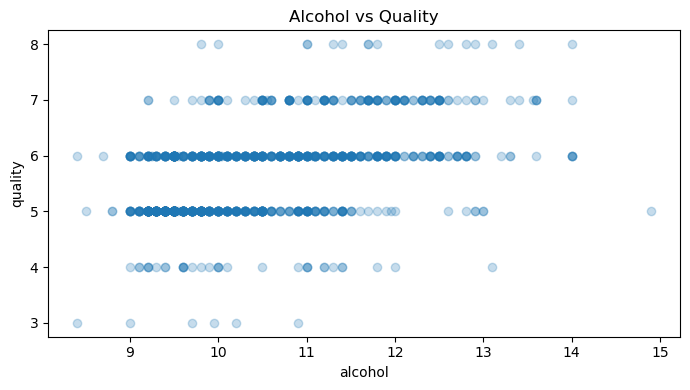

In [13]:
plt.figure(figsize=(7,4))
plt.scatter(wine_quality["alcohol"], wine_quality["quality"], alpha=0.25)
#plt.axvline(12.5, linestyle="--")
plt.title("Alcohol vs Quality")
plt.xlabel("alcohol")
plt.ylabel("quality")
plt.tight_layout()
plt.show()


## Correlation analysis (Pearson)

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = wine_quality.select_dtypes(include="number")


In [15]:
pearson_corr = numeric_cols.corr(method="pearson")
pearson_quality = pearson_corr[["quality"]].sort_values(by="quality")


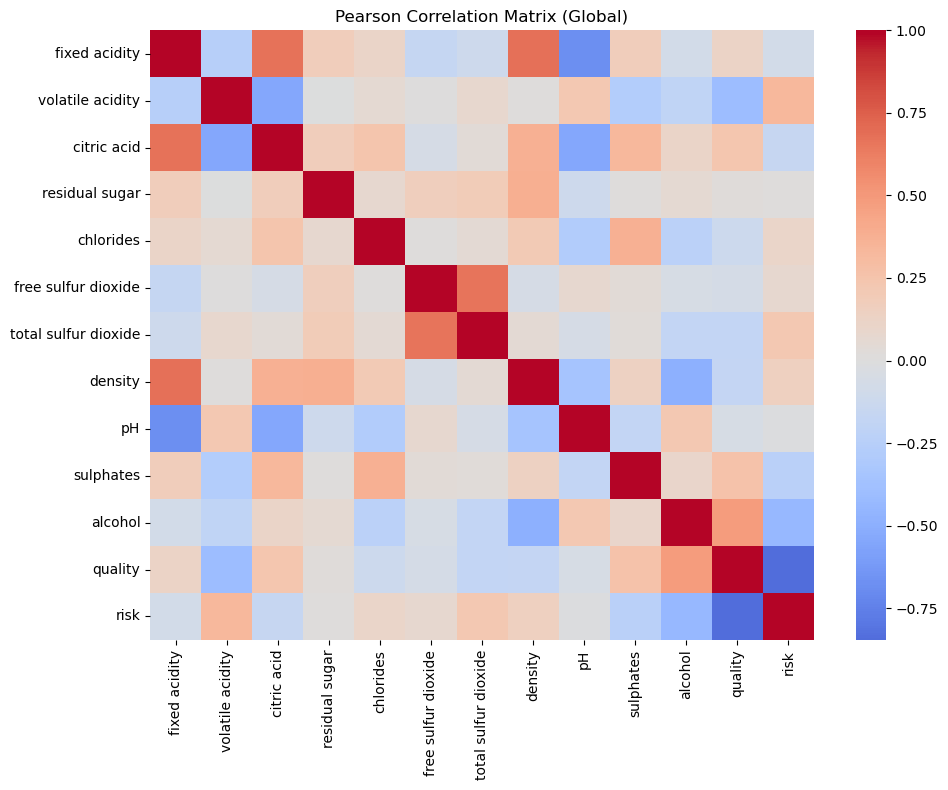

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_corr,
    cmap="coolwarm",
    center=0
)
plt.title("Pearson Correlation Matrix (Global)")
plt.tight_layout()
plt.show()


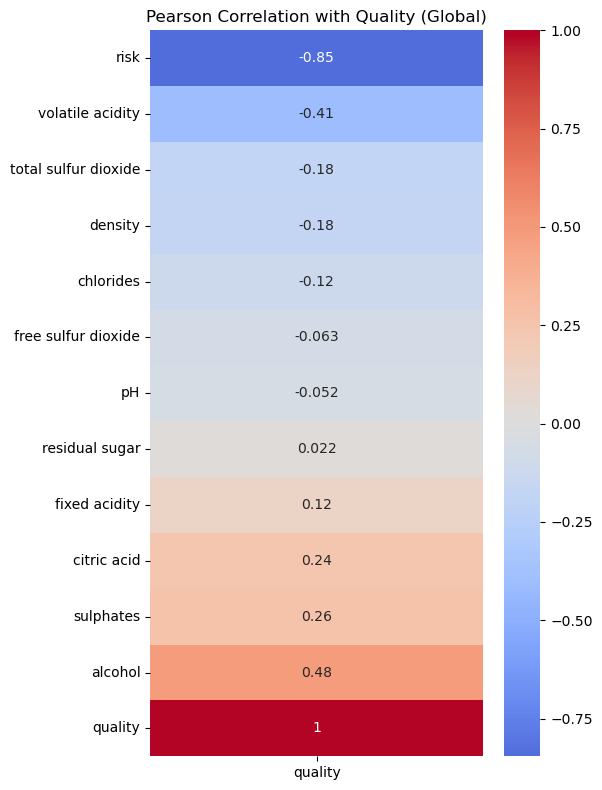

In [17]:
plt.figure(figsize=(6, 8))
sns.heatmap(
    pearson_quality,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Pearson Correlation with Quality (Global)")
plt.tight_layout()
plt.show()


Pearson correlation highlights: Volatile acidity stands out as a key risk-relevant variable: higher volatile acidity aligns with lower quality

## Correlation analysis (Spearman)


In [18]:
# is more robust to outliers than Pearson

import numpy as np

numeric_cols = wine_quality.select_dtypes(include=np.number).columns

spearman_corr =wine_quality[numeric_cols].corr(method="spearman")

spearman_corr


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,risk
fixed acidity,1.000000,-0.271597,0.653749,0.242521,0.272554,-0.190341,-0.093900,0.629644,-0.707010,0.194222,-0.085751,0.103887,-0.070049
volatile acidity,-0.271597,1.000000,-0.601305,0.012988,0.153031,0.021178,0.101862,0.019111,0.222106,-0.343500,-0.223379,-0.397784,0.335557
citric acid,0.653749,-0.601305,1.000000,0.210283,0.142182,-0.075070,0.007291,0.354884,-0.544998,0.340666,0.090691,0.222882,-0.154733
residual sugar,0.242521,0.012988,0.210283,1.000000,0.201531,0.051230,0.124370,0.422578,-0.108683,0.030979,0.123493,0.030614,-0.012304
chlorides,0.272554,0.153031,0.142182,0.201531,1.000000,0.002484,0.126247,0.426509,-0.249068,0.001763,-0.309720,-0.193814,0.172789
free sulfur dioxide,-0.190341,0.021178,-0.075070,0.051230,0.002484,1.000000,0.793745,-0.071330,0.113952,0.028295,-0.064219,-0.059213,0.054406
total sulfur dioxide,-0.093900,0.101862,0.007291,0.124370,0.126247,0.793745,1.000000,0.109786,-0.001788,-0.010544,-0.243461,-0.194570,0.195308
density,0.629644,0.019111,0.354884,0.422578,0.426509,-0.071330,0.109786,1.000000,-0.316985,0.154057,-0.471354,-0.176505,0.157552
pH,-0.707010,0.222106,-0.544998,-0.108683,-0.249068,0.113952,-0.001788,-0.316985,1.000000,-0.063352,0.195499,-0.033205,-0.012818
sulphates,0.194222,-0.343500,0.340666,0.030979,0.001763,0.028295,-0.010544,0.154057,-0.063352,1.000000,0.198741,0.393681,-0.358104


In [19]:
# --- Feature association with quality: Spearman
spearman_corr["quality"].sort_values(ascending=False)


quality                 1.000000
alcohol                 0.495439
sulphates               0.393681
citric acid             0.222882
fixed acidity           0.103887
residual sugar          0.030614
pH                     -0.033205
free sulfur dioxide    -0.059213
density                -0.176505
chlorides              -0.193814
total sulfur dioxide   -0.194570
volatile acidity       -0.397784
risk                   -0.932238
Name: quality, dtype: float64

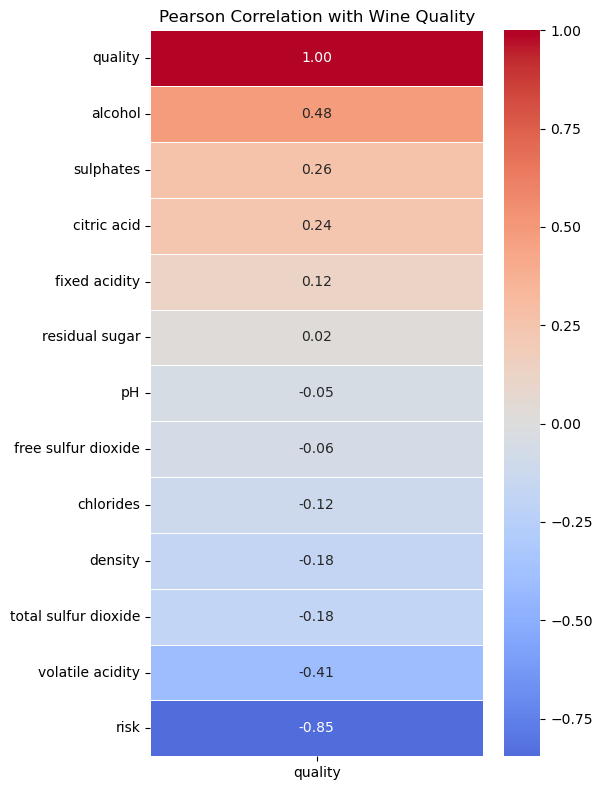

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pearson correlation with target variable
pearson_corr = wine_quality.corr(method="pearson")[["quality"]].sort_values(
    by="quality", ascending=False
)

plt.figure(figsize=(6, 8))
sns.heatmap(
    pearson_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Pearson Correlation with Wine Quality")
plt.tight_layout()
plt.show()


Spearman correlation is computed in addition to Pearson to capture monotonic
relationships that may not be strictly linear. This is especially relevant
for chemical variables where threshold or saturation effects are expected.


Spearman correlation confirms and strengthens the main associations observed with Pearson, while highlighting monotonic effects for alcohol, volatile acidity, and sulphates that may not be strictly linear.

## Alcohol range analysis
Alcohol content is known to be strongly associated with wine quality.
However, extreme alcohol values may correspond to specific wine styles
and represent a small fraction of the dataset. Before applying any
filtering, we explore the distribution of alcohol and its relationship
with quality.


In [21]:
# --- Alcohol distribution
wine_quality["alcohol"].describe()


count    1143.000000
mean       10.442111
std         1.082196
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64

<Axes: title={'center': 'Alcohol distribution'}, ylabel='Frequency'>

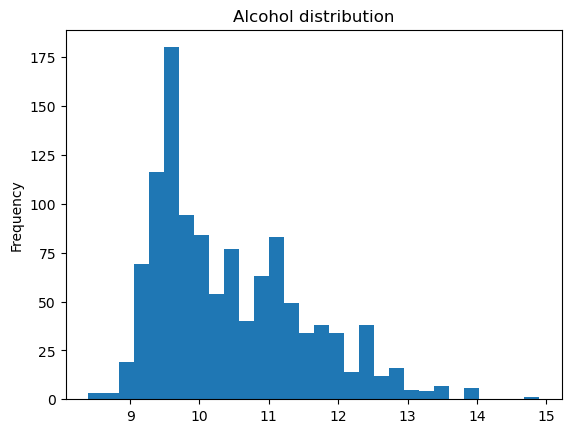

In [22]:
wine_quality["alcohol"].plot(
    kind="hist",
    bins=30,
    title="Alcohol distribution"
)


To better understand how alcohol values are distributed, we group wines
into meaningful alcohol ranges and count observations per group.


In [23]:
# --- Alcohol ranges
alcohol_bins = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 11, 12, 12.5, 13, 20]
)

alcohol_bins.value_counts().sort_index()


alcohol
(0.0, 10.0]     534
(10.0, 11.0]    307
(11.0, 12.0]    199
(12.0, 12.5]     52
(12.5, 13.0]     31
(13.0, 20.0]     20
Name: count, dtype: int64

We compare the number of wines and their average quality across alcohol
ranges to assess whether high-alcohol wines behave differently from
the rest of the dataset.


In [24]:
# --- Quality by alcohol range
wine_quality.groupby(alcohol_bins)["quality"].agg(
    ["count", "mean", "median"]
)


C:\Users\Marta\AppData\Local\Temp\ipykernel_31264\2070060426.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wine_quality.groupby(alcohol_bins)["quality"].agg(


,count,mean,median
alcohol,,,
"(0.0, 10.0]",534,5.314607,5.0
"(10.0, 11.0]",307,5.713355,6.0
"(11.0, 12.0]",199,6.080402,6.0
"(12.0, 12.5]",52,6.557692,7.0
"(12.5, 13.0]",31,6.225806,6.0
"(13.0, 20.0]",20,6.500000,6.5


This analysis allows us to assess whether wines above a certain alcohol
threshold represent a small and potentially distinct subset of the data.
If high-alcohol wines are scarce and show different quality patterns,
filtering by alcohol range may improve model robustness.


The alcohol range analysis shows a clear pattern up to 12.5% alcohol: as alcohol
increases, both mean and median wine quality consistently increase. This confirms
the strong monotonic relationship observed in both Pearson and Spearman correlations.

However, wines above 12.5% alcohol represent a very small fraction of the dataset
(51 wines, approximately 4.5%) and no longer follow this smooth trend. In these
higher alcohol ranges, average quality fluctuates and sample sizes are very small,
suggesting higher variability and potential noise.

These results indicate that high-alcohol wines may correspond to specific styles
and form a distinct, low-density subset of the data. This motivates evaluating
alcohol range filtering in later modeling steps to improve robustness.
